### 1) Load necessary Python packages

In [37]:
import os
import sys
import dill

# Add the local src directory to the path
sys.path.append('./src/')

# Load the GBA_model class
from GBA_model import *

### 2) Define a function to load a model from a binary backup
See the script `csv_to_binary.py`.

In [38]:
### Load the model from a binary file ###
def load_model( model_name ):
    filename = "./binary_models/"+model_name+".gba"
    assert os.path.isfile(filename), "ERROR: model not found."
    ifile = open(filename, "rb")
    model = dill.load(ifile)
    ifile.close()
    return model

### 3) Load the model "EC12b" (a very abstract model of <em>E. coli</em>)

In [39]:
# I previously saved the model as a binary file with the script `csv_to_binary.py`
#model = load_model("C")

### 4) Define the condition
The condition defines the environmental state of the cell (the composition of the medium). External concentrations are stored in the vector $x$.
Conditions are listed for the EC12b model in `./csv_models/EC12b/conditions.csv`.
We will use the condition 1.

In [40]:
#model.set_condition("1")

In [41]:
#model.solve_local_linear_problem()

### 6) Calculate all model variables

In [42]:
#model.calculate()

In [43]:
def saveValues(model,condition,nameOfCSV=None):
  dict_arrays = {
    "Max_growthrate": model.mu,
    "F-Vector": model.f,
    "Protein_concentrations vector" : model.p,
    "GCC_F": model.GCC_f,
    "Fluxes_vector" : model.v,
    "Internal_Metabolite_concentrations": model.c,
    "External_metabolite_concentrations": model.x,
    "Metabolite_concentrations": model.xc,
  }
  dict_arrays_str = {k: [str(v)] for k, v in dict_arrays.items()}

  # Erstellen des DataFrames
  df = pd.DataFrame(dict_arrays_str)

  # Speichern des DataFrames als CSV
  df.to_csv("Values_at_Max "+model.model_name+" "+condition+".csv", sep=',', index=False)

  print(df)

In [44]:
import matplotlib.pyplot as plt
def plotTrajectory(timestamps, muRates):
  # Daten für die Zeitachse
  t = timestamps  # 100 Zeitpunkte von 0 bis 10

  # Daten für die Y-Achse (Beispiel: Sinusfunktion)
  mu = muRates

  # Erstellung des Plots
  plt.figure(figsize=(8, 6))  # Größe des Diagramms festlegen
  plt.plot(t, mu, label='mu(t)')  # Plot der Daten
  plt.xlabel('Time')  # Beschriftung der X-Achse
  plt.ylabel('mu')    # Beschriftung der Y-Achse
  plt.title('Plot of mu against Time')  # Titel des Diagramms
  plt.grid(True)      # Gitterlinien aktivieren
  plt.legend()        # Legende hinzufügen
  plt.show()          # Diagramm anzeigen
  print("max μ rate :")
  print(np.max(mu))
  return 

 current mu-Rate 0.13291406868329347
time : 0
no Mu alterations:  1
current protein [  1.56506237   0.66492806   0.49869605   0.          45.21883273
   2.24967549  26.64638311   9.8961773    0.23579216   8.40092515
  66.96615308 102.05737449]
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: False
 current mu-Rate -0.06950627524029608
time : 0.001
no Mu alterations:  2
current protein [-8.46888704e-01 -3.34827230e-01 -2.47511496e-01  3.45752047e-06
 -1.77336101e+02 -7.00323882e+00  5.10100816e+00 -5.67829937e+00
 -3.12649819e-02 -1.61113760e+00  4.48150419e+02 -7.85076794e+00]
>>> Model state is not consistent:
    ------------------------------
    • Density constraint: True
    • Positive c: False
    • Positive p: True
 current mu-Rate 1.729416749120196
time : 0.0011
no Mu alterations:  3
current protein [ 2.47488808e+01  4.85438542e+00  5.80052082e+00 -2.33258552e-06
  1.33134751e+01  1.85

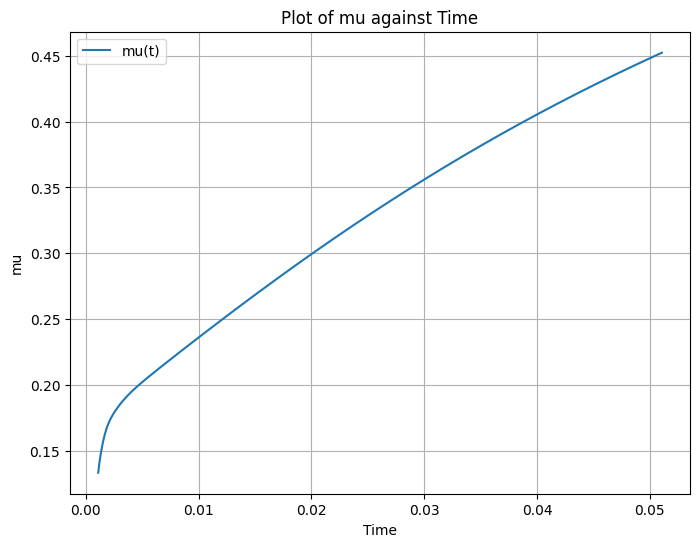

max μ rate :
0.45228923779048785
        Max_growthrate                                           F-Vector  \
0  0.45228923779048785  [ 5.55247836e-01  2.23058901e-01  2.21693264e-...   

                       Protein_concentrations vector  \
0  [ 5.29387564e+00  2.28677518e+00  1.70458111e+...   

                                               GCC_F  \
0  [ 0.          0.04783787  0.03356048 -0.009232...   

                                       Fluxes_vector  \
0  [ 8.53850909e+01  3.43016277e+01  3.40916223e+...   

                  Internal_Metabolite_concentrations  \
0  [  7.55303698   5.76793806   5.3036215    1.67...   

              External_metabolite_concentrations  \
0  [4.16666667 1.         1.         1.        ]   

                           Metabolite_concentrations  
0  [  4.16666667   1.           1.           1.  ...  


AssertionError: trajectory was stopped, because the growthrate did not increase significantly for 5000 tries. 

In [45]:
def trajectory(model_name="A",condition="1",max_time=5,first_dt = 0.01,dt_changeRate=0.1,nameOfCSV=None):
  model = load_model(model_name)      #load and run model
  model.set_condition(condition)      #set condition of model
  model.solve_local_linear_problem()  #solve first linear problem
  model.calculate()                   #calc for the first time (maybe not needed)

  dt = first_dt
  t = 0                              # time
  previous_mu = model.mu
  mu_alterationCounter = 0              #setup counter for error criteria
  consistent_f = np.copy(model.f_trunc) # safes consistent_f
  next_f = np.copy(model.f_trunc)     # the f_trunc, that we are going to change
  allGCC_F = [model.GCC_f[1:]]       # to collect all previous GCC_f (just for checking the change of GCC_f)

  y_muRates = []                      #save muRates for plotting
  timestamps = []                     #save timeStamps for plotting

  while (t < max_time):                                                                 # end loop if time is up
    print(" current mu-Rate",model.mu)
    print("time :",t)
    previous_mu = model.mu
    if( ( np.abs(model.GCC_f) <= TRAJECTORY_CONVERGENCE_TOL ).all() and model.consistent):               #(maybe use mu and look if it doesnt change for the next x steps , stop)
      
      break
    
    if(model.mu - previous_mu <= TRAJECTORY_CONVERGENCE_TOL):                                            #maybe decrease Trajectory_Convergence_Tol to 
      mu_alterationCounter = mu_alterationCounter + 1
      #print(mu_alterationCounter)
    else:
        mu_alterationCounter = 0

    if(mu_alterationCounter >= TRAJECTORY_STABLE_MU_COUNT):
        plotTrajectory(timestamps, y_muRates)
        saveValues(model,condition,nameOfCSV)
        raise AssertionError("trajectory was stopped, because the growthrate did not increase significantly for " + str(TRAJECTORY_STABLE_MU_COUNT) + " tries. ")

        break
    
    if np.any(next_f < 0):                                                            #negative value correction
       #print("next_f before neg.correction:", next_f)
       next_f[next_f < 0] = 1e-10
       #print("next_f after neg.correction:", next_f)

    print("no Mu alterations: ",mu_alterationCounter)
    #print("current gradient :", model.GCC_f)
    print("current protein",model.p)
    #print("current Metabolite :",model.c)

    next_f = np.add(next_f, model.GCC_f[1:] * dt)                                      # add without first index of GCC_f

    model.set_f(next_f)
    model.calculate()                                                             #calculate everything
    model.check_model_consistency()                                               #check consistency

    if (model.consistent):
      timestamps = np.append(timestamps,t)
      y_muRates = np.append(y_muRates,model.mu)

      t = t + dt                                                                  # calc. new t
      consistent_f = next_f                                                       # saves new f as the consistent f

    else:
      next_f = consistent_f                                                       #resets next_f to last consistent_f
      model.set_f(consistent_f)

      if (dt > 1e-100):                                                           # make sure dt is not too small
       dt = dt * dt_changeRate
       t = t + dt                                                                 # calc. new t

      else:
        raise AssertionError("trajectory was stopped, because dt got too small")
        break
      
  plotTrajectory(timestamps, y_muRates)
  saveValues(model,condition)
  
  print ("Maximum was found, Model is consistent")
  return 

trajectory(model_name="EC12b",condition="2",max_time=5,first_dt = 0.01,dt_changeRate=0.1)

